In [3]:
import torch
import numpy as np

from src.data.box import GravityHoleBall
from src.data.generate import generate_gravity_hole_ball_images, add_average_velocity

from src.utils.utils import add_spatial_encoding, gaussian_density
from src.utils.node import train, BatchGetterMultiTrajectories
from src.utils.viz import plot_tsne_and_pca, plot_tsne_and_pca_portrait, display_ode_trajectory

from src.models.ae import ConvAE
from src.models.node import ODEnetSimple
from src.models.anode import ANODENet

In [4]:
MARGIN_MIN = 5
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3

infos = {
    "MARGIN_MIN":MARGIN_MIN,
    "MIN_INIT_VELOCITY":MIN_INIT_VELOCITY,
    "WIDTH":WIDTH,
    "HEIGHT":HEIGHT,
    "RADIUS":RADIUS
}


In [5]:
x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)

# Fit an ODE on the true position + velocity using several trajectories

In [5]:
from src.generate_data import generate_gravity_hole_ball_positions_and_velocity

In [7]:
N = 200
N_frames = 300
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)

encoded_trajectory = generate_gravity_hole_ball_positions_and_velocity(box, N, N_frames, dt, infos)
print(encoded_trajectory.shape)



100%|██████████| 200/200 [00:00<00:00, 303.56it/s]

(200, 300, 4)


In [8]:
batch_time = 200
n_samples = 1
total_length = N_frames

getter = BatchGetterMultiTrajectories(batch_time, n_samples, total_length, dt, encoded_trajectory, frac_train=1.)

In [9]:
from src.viz import display_results

In [10]:
latent_dim = 4
device = "cpu"
data_dim = latent_dim
hidden_dim = 64
output_dim = latent_dim
augment_dim = 0
anode = ANODENet(device, data_dim, hidden_dim, output_dim, augment_dim, time_dependent=False)

The graphs at epoch 0


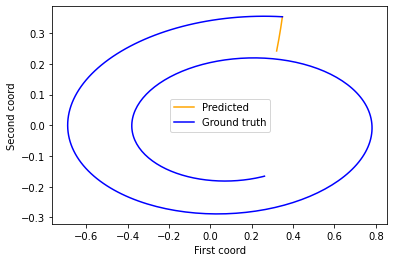

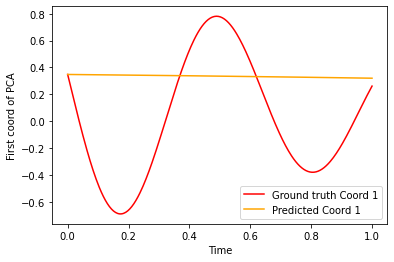

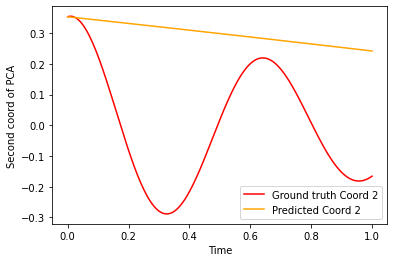

In [11]:
display_results(0, anode, getter, final_time=N_frames, dt=dt)

In [63]:
optimizer = torch.optim.Adam(anode.parameters(), lr=4e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
batch_size = 1
epochs = 100000

In [ ]:
train(anode, optimizer, scheduler, epochs, batch_size, getter, display=5000, display_results_fn=display_results)

In [70]:
# save the anode model that generalized true position
pathODE = "models/AE_ODE/anode_on_ground_truth_values_gravity_1_ball_{}_{}_{}_more_friction_and_gravity".format(latent_dim, hidden_dim, augment_dim)
torch.save(anode.state_dict(), pathODE)

# Fit an ODE on the latent position + latent approximation velocity using several trajectories

In [5]:
Num_pos_velocity = 1
N = 10
N_frames = 300 + Num_pos_velocity
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)

dataset = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt, infos=infos).reshape(-1, 1, HEIGHT, WIDTH)
print(dataset.shape)
# dataset = [(image, 0) for image in dataset]
# dataset = add_spatial_encoding(dataset)
# print(len(dataset), len(dataset[0]), dataset[0][0].shape)
dataset = torch.from_numpy(add_spatial_encoding(dataset)).float()
print(dataset.shape)

100%|██████████| 10/10 [00:00<00:00, 32.48it/s]


(3010, 1, 28, 28)
torch.Size([3010, 3, 28, 28])


In [6]:
latent_dim_model = 25
activation = "ReLU"
activation_fn = getattr(torch.nn, activation)
# path = "models/AE/ae_1_Ball_with_sp_latent_{}.pth".format(latent_dim)
# path = "models/AE/ae_1_Ball_with_sp_latent_{}_no_relu.pth".format(latent_dim)
# Good: SiLU with 10 latent dim, GELU with 6 latent dim
path = "models/AE/AE_with_smooth_activation/ae_1_Ball_with_sp_latent_{}_no_relu_activation_{}_no_margin.pth".format(latent_dim_model, activation)

ae = ConvAE(height=HEIGHT, width=WIDTH, in_channels=3, latent_dim=latent_dim_model, relu=False, activation=activation_fn)
print(ae.load_state_dict(torch.load(path)))

encoded_trajectory = ae.encode(dataset).reshape(N, N_frames, latent_dim_model).detach()
print(encoded_trajectory.shape)

Number of parameters in the model: 276028
<All keys matched successfully>
torch.Size([10, 301, 25])


In [7]:
# prepare data to contains positions and velocity
print(encoded_trajectory.shape)
encoded_trajectory = add_average_velocity(encoded_trajectory, Num_pos_velocity, dt)
print(encoded_trajectory.shape)

torch.Size([10, 301, 25])
torch.Size([10, 300, 50])


In [8]:
batch_time = 100
n_samples = 1
total_length = N_frames - Num_pos_velocity

getter = BatchGetterMultiTrajectories(batch_time, n_samples, total_length, dt, encoded_trajectory, frac_train=1.)

In [9]:
latent_dim = latent_dim_model*(1 + 1)
device = "cpu"
data_dim = latent_dim
hidden_dim = 128
output_dim = latent_dim
augment_dim = 0
anode = ANODENet(device, data_dim, hidden_dim, output_dim, augment_dim, time_dependent=False)
pathModel = "models/AE_ODE/MultiTrajectories/anode_1_Ball_with_sp_latent_25_velocity_1_hidden_dim_128_no_relu_activation_ReLU_no_margin.pth"
anode.load_state_dict(torch.load(pathModel))

<All keys matched successfully>

The graphs at epoch 0


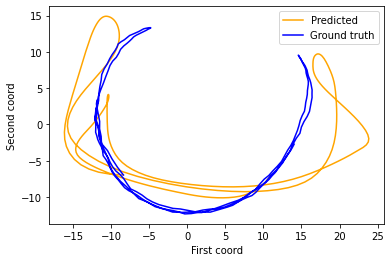

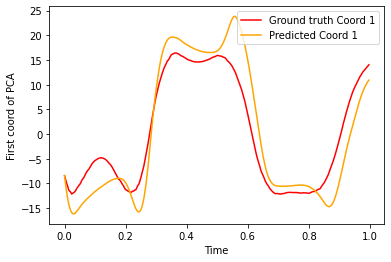

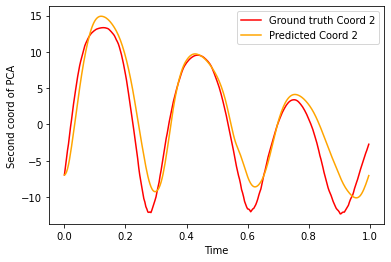

In [10]:
display_ode_trajectory(0, anode, latent_dim_model, getter, final_time=total_length, dt=dt)

In [11]:
optimizer = torch.optim.Adam(anode.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.99)
batch_size = 16
epochs = 10000

  0%|          | 1/10000 [00:00<52:08,  3.20it/s, Loss: 157.98924255]

The graphs at epoch 2


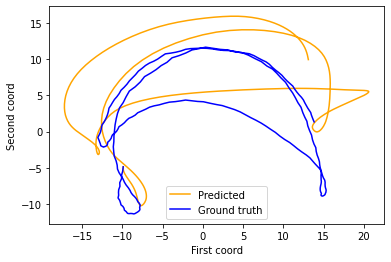

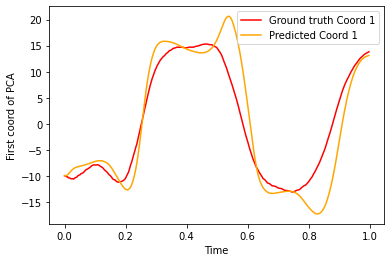

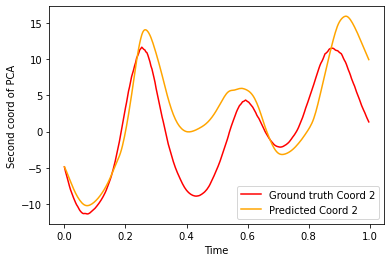

Display loss: 171.70394897:   0%|          | 3/10000 [00:01<1:02:39,  2.66it/s, Loss: 280.32647705]

The graphs at epoch 4


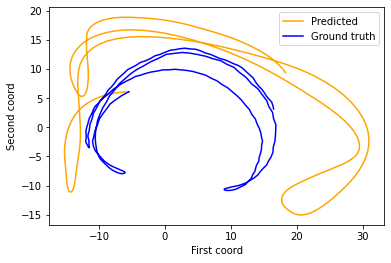

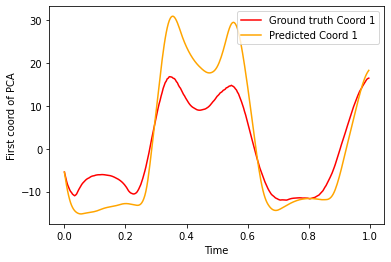

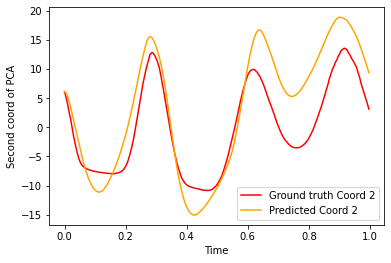

Display loss: 233.55194855:   0%|          | 5/10000 [00:02<1:05:20,  2.55it/s, Loss: 343.46954346]

The graphs at epoch 6


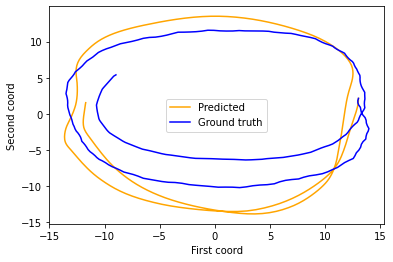

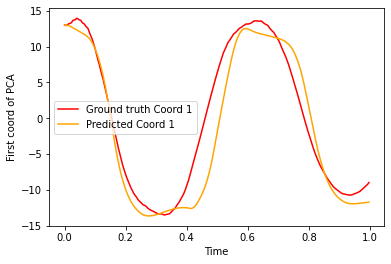

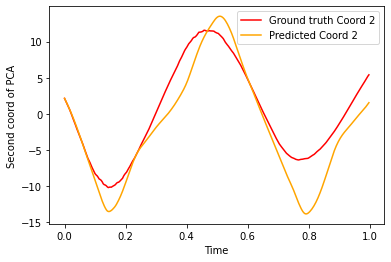

Display loss: 300.04788208:   0%|          | 7/10000 [00:03<1:08:42,  2.42it/s, Loss: 232.92576599]

The graphs at epoch 8


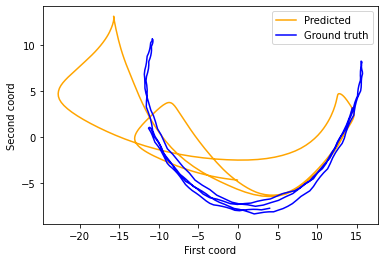

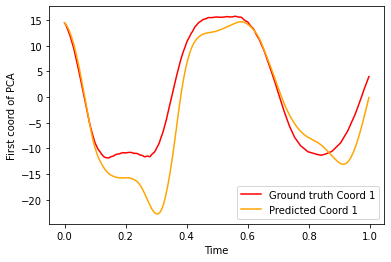

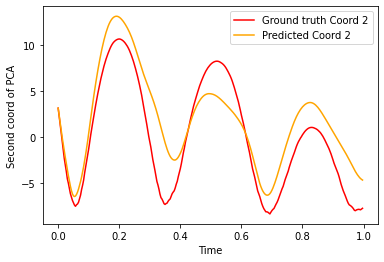

Display loss: 235.02116394:   0%|          | 9/10000 [00:04<1:06:53,  2.49it/s, Loss: 169.44456482]

The graphs at epoch 10


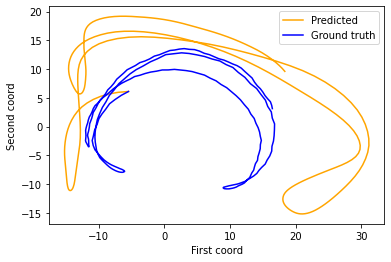

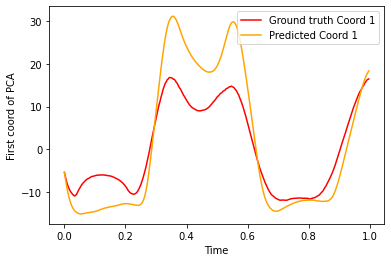

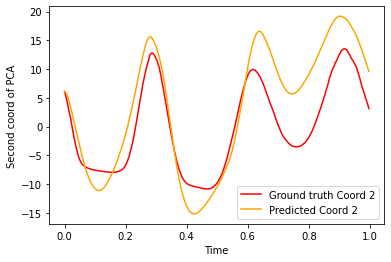

Display loss: 263.58837128:   0%|          | 11/10000 [00:04<1:06:31,  2.50it/s, Loss: 189.72364807]

The graphs at epoch 12


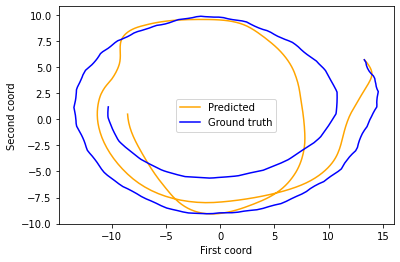

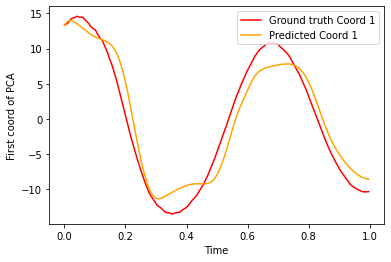

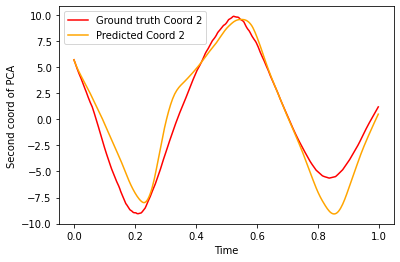

Display loss: 214.35094452:   0%|          | 13/10000 [00:05<1:07:50,  2.45it/s, Loss: 148.21018982]

The graphs at epoch 14


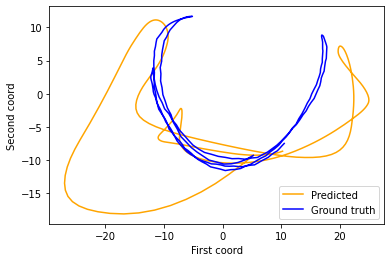

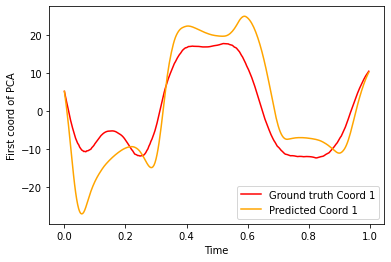

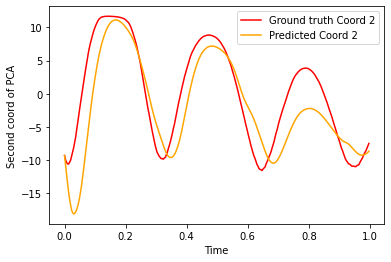

Display loss: 216.72043610:   0%|          | 15/10000 [00:06<1:08:00,  2.45it/s, Loss: 366.39608765]

The graphs at epoch 16


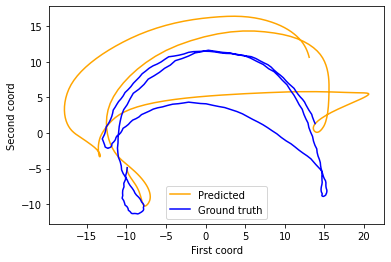

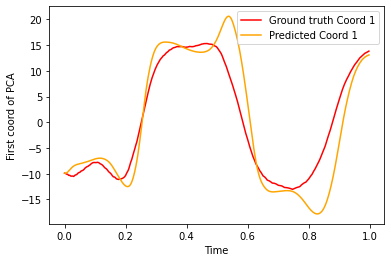

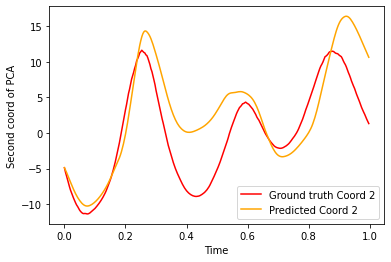

Display loss: 326.76742554:   0%|          | 17/10000 [00:07<1:09:16,  2.40it/s, Loss: 134.42152405]

The graphs at epoch 18


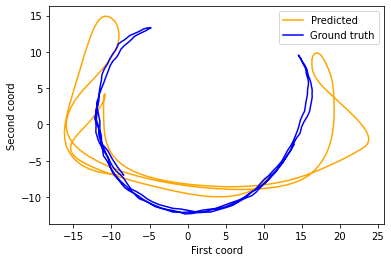

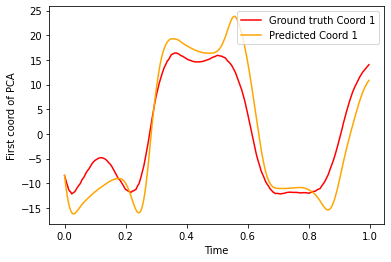

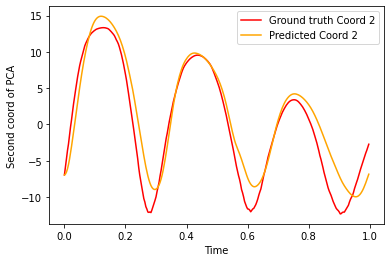

Display loss: 140.38719177:   0%|          | 18/10000 [00:07<1:11:07,  2.34it/s, Loss: 134.42152405]


KeyboardInterrupt: 

In [12]:
train(anode, optimizer, scheduler, epochs, batch_size, getter, display=2, display_results_fn=display_ode_trajectory, out_display=latent_dim_model) 

In [28]:
# torch.save(anode.state_dict(), "models/AE_ODE/MultiTrajectories/anode_1_Ball_with_sp_latent_{}_velocity_{}_hidden_dim_{}_no_relu_activation_{}_no_margin.pth".format(latent_dim_model, Num_pos_velocity, hidden_dim, activation))


# save the trajectories
# torch.save(encoded_trajectory, "models/AE_ODE/MultiTrajectories/trajectory_1_Ball_with_sp_latent_{}_velocity_{}_hidden_dim_{}_no_relu_activation_{}_no_margin.pth".format(latent_dim_model, Num_pos_velocity, hidden_dim, activation))

In [24]:
print("models/AE_ODE/anode_1_Ball_with_sp_latent_{}_velocity_{}_hidden_dim_{}_no_relu_activation_{}_no_margin.pth".format(latent_dim_model, Num_pos_velocity, hidden_dim, activation))

models/AE_ODE/anode_1_Ball_with_sp_latent_25_velocity_1_hidden_dim_128_no_relu_activation_ReLU_no_margin.pth
